In [1]:
!pip install yfinance
import yfinance as yf 
import pandas as pd

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
symbols = "SPY"
yf_period = "32y" #from 1990
yf_interval = "1d"
yf_returns = yf.download(
        tickers = symbols,       # tickers list or string as well
        period = yf_period,      # optional, default is '1mo'
        interval = yf_interval,  # fetch data by intervaal
        group_by = 'ticker',     # group by ticker
        auto_adjust = True,      # adjust all OHLC (open-high-low-close)
        prepost = False,#True,          # download market hours data
        threads = True,          # threads for mass downloading
        proxy = None)            # proxy
yf_returns.head(3)

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Volume
Date,,,,,
1993-01-29 00:00:00-05:00,25.352058,25.352058,25.225929,25.334040,1003200
1993-02-01 00:00:00-05:00,25.352032,25.514198,25.352032,25.514198,480500
1993-02-02 00:00:00-05:00,25.496190,25.586283,25.442134,25.568264,201300


In [3]:
snp = yf_returns["Close"].to_numpy()
snp.shape

(7476,)

In [4]:
 date = yf_returns.index.strftime("%Y-%m-%d").tolist()

In [5]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from tqdm import tqdm
if torch.cuda.is_available():
  print(torch.cuda.get_device_name(0))
import multiprocessing, random
NUM_WORKERS = multiprocessing.cpu_count()
print(NUM_WORKERS)
import numpy as np

2


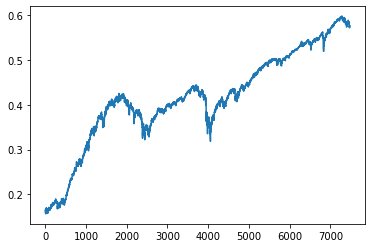

In [6]:
#y_itrcpt = snp[0]
plt.plot([i for i in range(snp.shape[0])], np.log(np.log(np.log(snp))))

In [7]:
raw_ds = np.log(np.log(np.log(snp)))#snp

In [8]:
#import numpy as np

In [9]:
myseed = 6666  
random.seed(myseed) #ADD
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(myseed)
torch.manual_seed(myseed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(myseed)

In [10]:
#raw_ds = (np.arange(50) /50) - 0.5
#raw_ds = np.sin(np.arange(200)/2)

In [11]:
def window(ds, wind_size):
  return np.vstack([ds[i:i+wind_size] for i in range(len(ds) - wind_size+1)])

WIND_SIZE = 10 #2 weeks
ds = window(raw_ds, WIND_SIZE)
#ds
#ds = np.array(np.split(ds, len(ds)/batch_size))
#ds #shape=(num_batch, batch_size, wind_size)

In [12]:
ds.shape

(7467, 10)

In [13]:
class StockDataset(Dataset):
  def __init__(self, data, mode, train_frac, val_frac):
    super(StockDataset).__init__()
    num_train = int(data.shape[0]*train_frac)
    num_val = int(data.shape[0]*val_frac)
    if mode == "train":
      data = torch.FloatTensor(data[:num_train])
    elif mode == "val":
      data = torch.FloatTensor(data[num_train : num_train+num_val])    
    elif mode == "test":
      data = torch.FloatTensor(data[num_train+num_val:]) 
      #all that's remaining goes to test  
    else:
      print("[ERROR] <mode> not provided for Dataset!")
    self.data = torch.unsqueeze(data[:,:-1], -1) #data[:,:-1] #input_size = 1 (univariate)
    self.label = torch.unsqueeze(data[:,-1], -1)

  def __getitem__(self, idx):
    # Returns one sample at a time
    return self.data[idx], self.label[idx]
    
  def __len__(self):
    # Returns the size of the dataset
    return len(self.data)

In [14]:
TRAIN_FRAC, VAL_FRAC = 0.7, 0.2
BATCH_SIZE = 32 #larger --> training loss more stable

train_set = StockDataset(ds, "train", TRAIN_FRAC, VAL_FRAC)
train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS, pin_memory=True)
val_set = StockDataset(ds, "val", TRAIN_FRAC, VAL_FRAC)
val_loader = DataLoader(val_set, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)
test_set = StockDataset(ds, "test", TRAIN_FRAC, VAL_FRAC)
test_loader = DataLoader(test_set, batch_size=1, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)

In [15]:
class RNN(nn.Module): #ML w/ Pytorch & Scikit-Learn
  def __init__(self, input_size, hidden_size, num_layers):
    super().__init__()
    #self.rnn = nn.RNN(input_size, hidden_size, num_layers,
    #                  batch_first=True)
    self.rnn = nn.GRU(input_size, hidden_size, num_layers,
                      batch_first=True)
    #self.rnn = nn.LSTM(input_size, hidden_size, num_layers,
    #                   batch_first=True)
    self.fc = nn.Linear(hidden_size, 1)

  def forward(self, x):
      _, hidden = self.rnn(x)
      out = hidden[-1, :, :] # use the final hidden state

      #out, hidden = self.rnn(x)
      #print("out.shape = ", out.shape)
      #out = out[:,:,-1]
      
      # from the last hidden layer as input to the FC layer
      out = self.fc(out) # out = logits
      return out

In [16]:
model = RNN(1, 64, 3) #Sunspot: 64 CNN, 64 hidden + 2 layers
#hidden_size = # of neurons in one layer
#input_size = 1, i.e. close price
print(model)
#input: [batch_size, time_steps, input_size (univariate / multivariate)] 

RNN(
  (rnn): GRU(1, 64, num_layers=3, batch_first=True)
  (fc): Linear(in_features=64, out_features=1, bias=True)
)


In [17]:
_EXP_NAME = "baseline"
N_EPOCHS = 2
device = "cuda" if torch.cuda.is_available() else "cpu"
criterion = nn.HuberLoss() #to account for outliers, instead of MSE nn.MSELoss()
#https://pytorch.org/docs/stable/nn.html#loss-functions
optimizer = torch.optim.Adam(model.parameters(), lr=0.0003, weight_decay=1e-5) 

train_pred, val_pred, train_loss_lst, val_loss_lst = [], [], [], []
for epoch in range(N_EPOCHS):
  train_loss, val_loss = [], []
  for mode in ["train", "val"]: #train then eval, for each ep
    data_loader = train_loader if mode=="train" else val_loader
    for x, label in tqdm(data_loader):
      #print("x.shape = ", x.shape) #[batch_size, time_steps, input_size (univariate / multivariate)] 
      #print("label.shape = ", label.shape) #[batch_size, 1 (univariate)]

      if mode=="train":
        model.train()
        logits = model(x.to(device))
      elif mode=="val":
        model.eval()
        with torch.no_grad(): 
        #no need grad in val, using torch.no_grad() accelerates forward pass.
            logits = model(x.to(device))
      loss = criterion(logits, label.to(device))*1000

      if mode=="train":
        # Gradients stored in the parameters in the previous step should be cleared out first.
        optimizer.zero_grad()
        loss.backward() #compute grad for params
        grad_norm = nn.utils.clip_grad_norm_(model.parameters(), max_norm=10) # Clip the gradient norms for stable training.
        optimizer.step() # Update the parameters with computed gradients.
      #acc = (logits.argmax(dim=-1) == labels.to(device)).float().mean()

      if mode=="train":
        train_loss.append(loss.item())
        #train_accs.append(acc)
        #if epoch == N_EPOCHS-1: #last ep
          #train_pred.append(np.squeeze(logits.cpu().detach().numpy()))
          #RuntimeError: Can't call numpy() on Tensor that requires grad

      elif mode=="val":
        val_loss.append(loss.item())
        #valid_accs.append(acc)
        if epoch == N_EPOCHS-1:
          val_pred.append(np.squeeze(logits.cpu().numpy()))
    
    if mode=="train": #avg over batches
      train_loss = sum(train_loss) / len(train_loss)
      train_loss_lst.append(train_loss)
      #train_acc = sum(train_accs) / len(train_accs)
    elif mode=="val":
      val_loss = sum(val_loss) / len(val_loss)
      val_loss_lst.append(val_loss)
      #valid_acc = sum(valid_accs) / len(valid_accs) 

  out = "[{:03d}/{:03d}] train_loss: {:.3f} | val_loss: {:.3f}\n".format(
      epoch + 1, N_EPOCHS, train_loss, val_loss)
  print(out)
  with open(f"./{_EXP_NAME}_log.txt","a") as f:
    print(out, file=f) 

100%|██████████| 47/47 [00:00<00:00, 203.82it/s]


[001/002] train_loss: 11.488 | val_loss: 0.007



100%|██████████| 47/47 [00:00<00:00, 184.23it/s]

[002/002] train_loss: 0.011 | val_loss: 0.001



In [18]:
test_loss, test_pred = [], []
for x, label in tqdm(test_loader):
  model.eval()
  with torch.no_grad(): 
  #no need grad in val, using torch.no_grad() accelerates forward pass.
      logits = model(x.to(device))
  #print(x, " ", logits)
  loss = criterion(logits, label.to(device))
  test_loss.append(loss.item())
  test_pred.append(float(np.squeeze(logits.cpu().numpy())))
test_loss = sum(test_loss) / len(test_loss)
print(test_loss)

100%|██████████| 748/748 [00:02<00:00, 347.03it/s]

3.628516338664362e-06


In [19]:

num_train = int(ds.shape[0]*TRAIN_FRAC)
num_val = int(ds.shape[0]*VAL_FRAC)
                                              #last seq in val_set, get latest window
val_end = ds[num_train : num_train+num_val][-1][-WIND_SIZE:]

test_pred2 = []
x = val_end
model.eval()
for i in range(len(raw_ds)-num_train-num_val-WIND_SIZE):
  x = torch.FloatTensor(np.expand_dims(np.expand_dims(x,-1),0)) 
  #(batch_size, window_size, num_feat) = (1, window_size, 1)
  with torch.no_grad():
    logits = model(x.to(device))
  #print(logits)
  logits = float(np.squeeze(logits.cpu().numpy())) #item: convert to native python
  test_pred2.append(logits)
  x = np.append(x[1:], logits)


In [20]:
#plot raw_ds, train_pred, val_pred, test_pred
#raw_ds = raw_ds.tolist()
#train_pred_lst = np.concatenate([*(train_pred[:-1])]).tolist()
num_train = int(ds.shape[0]*TRAIN_FRAC)
num_val = int(ds.shape[0]*VAL_FRAC)
val_pred_lst = np.concatenate([*(val_pred[:-1])]).tolist()

#for i in train_pred[-1]:
#  train_pred_lst.append(float(i))
if len(val_pred[-1].shape) > 0:
  for i in val_pred[-1]:
    val_pred_lst.append(float(i))
else:
  val_pred_lst.append(float(val_pred[-1]))


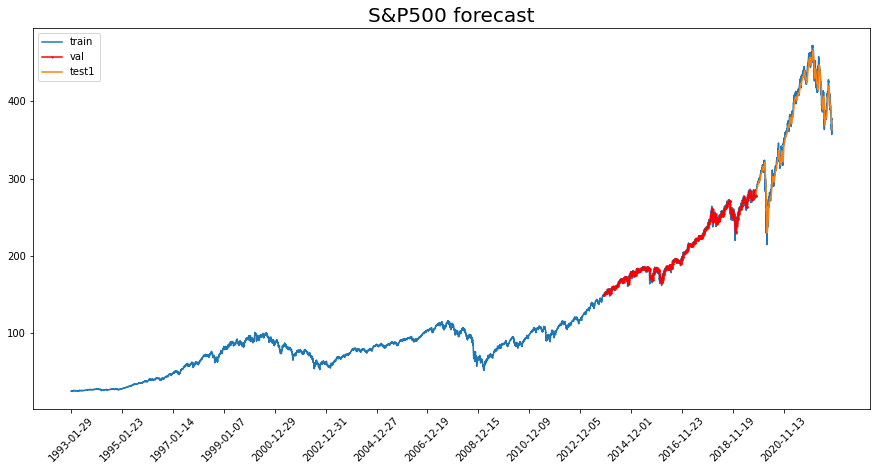

In [21]:
fig, ax = plt.subplots(figsize=(15,7))
plt.plot(date, np.exp(np.exp(np.exp(np.array(raw_ds)))))
#plt.plot([i+WIND_SIZE for i in range(num_train)], train_pred, 'o')
plt.plot(date[num_train+WIND_SIZE: num_train+WIND_SIZE+num_val], np.exp(np.exp(np.exp(np.array(val_pred_lst)))),color="red", marker='o', markersize=1)
plt.plot(date[num_train+num_val+WIND_SIZE-1:], np.exp(np.exp(np.exp(np.array(test_pred)))))
#plt.plot(date[num_train+num_val+WIND_SIZE:], np.exp(np.exp(np.exp(np.array(test_pred2)))))
plt.title("S&P500 forecast", fontsize=20)
ax.set_xticks(date[::500])
ax.set_xticklabels(date[::500], rotation=45)

plt.legend(["train", "val", "test1"],loc="upper left")
#https://stackoverflow.com/questions/50128668/how-to-adjust-tick-frequency-for-string-x-axis

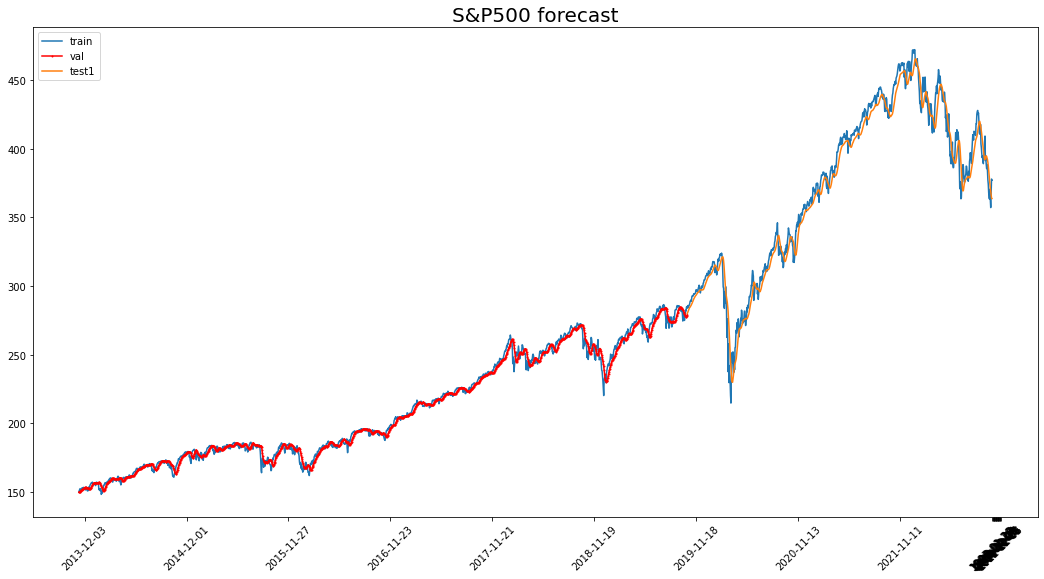

In [30]:
fig, ax = plt.subplots(figsize=(18,9))
plt.plot(date[num_train+WIND_SIZE:], np.exp(np.exp(np.exp(np.array(raw_ds))))[num_train+WIND_SIZE:])
#plt.plot([i+WIND_SIZE for i in range(num_train)], train_pred, 'o')
plt.plot(date[num_train+WIND_SIZE: num_train+WIND_SIZE+num_val], np.exp(np.exp(np.exp(np.array(val_pred_lst)))),color="red", marker='o', markersize=1)
plt.plot(date[num_train+num_val+WIND_SIZE-1:], np.exp(np.exp(np.exp(np.array(test_pred)))))
#plt.plot(date[num_train+num_val+WIND_SIZE:], np.exp(np.exp(np.exp(np.array(test_pred2)))))
plt.title("S&P500 forecast", fontsize=20)
ax.set_xticks(date[::250])
ax.set_xticklabels(date[::250], rotation=45)

plt.legend(["train", "val", "test1"],loc="upper left")

In [24]:
from sklearn.metrics import mean_absolute_percentage_error
mean_absolute_percentage_error(np.exp(np.exp(np.exp(np.array(raw_ds))))[num_train+num_val+WIND_SIZE-1:], np.exp(np.exp(np.exp(np.array(test_pred)))))

0.020224200807808963

In [25]:
from sklearn.metrics import mean_absolute_error
mean_absolute_error(np.exp(np.exp(np.exp(np.array(raw_ds))))[num_train+num_val+WIND_SIZE-1:], np.exp(np.exp(np.exp(np.array(test_pred)))))

7.281180327893305

In [ ]:
plt.plot([i for i in range(len(train_loss_lst))], train_loss_lst)
plt.plot([i for i in range(len(val_loss_lst))], val_loss_lst)

### Reference
[1] https://www.coursera.org/learn/tensorflow-sequences-time-series-and-prediction/home/week/4

[2] Machine Learning with PyTorch and Scikit-Learn, by Sebastian Raschka